# Analyze Development EEG Data 

Analyze EEG data. 

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

from bootstrap import bootstrap_corr, bootstrap_diff

In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.plts import plot_dots
from apm.utils import format_corr
from apm.methods import specparam, irasa, dfa, hurst, hjorth_complexity, lempelziv, app_entropy

## Settings

In [3]:
# Data path
data_path = Path('/Users/tom/Documents/Data/VoytekLab/ExtractedSubsets/childmind/')

In [4]:
# Define data information
fs = 500
n_seconds = 30

In [5]:
# Define times vector for data
times = create_times(n_seconds + 1/fs, fs)

## Load Data

In [6]:
# Load data files
ages = np.load(data_path / 'ages.npy')
data = np.load(data_path / 'data.npy')

In [7]:
# Check the number of subjects
n_subjs = data.shape[0]
assert n_subjs == len(ages)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 111


## Data Checks

In [8]:
ind = 0

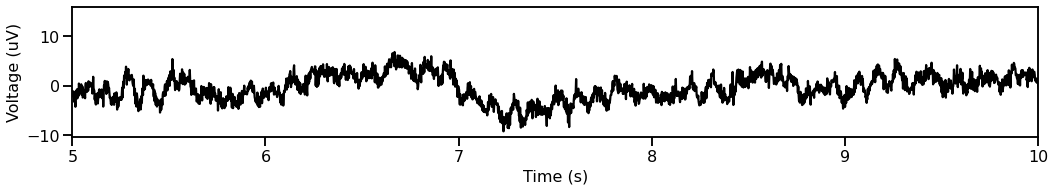

In [9]:
# Plot a segment of time series data
plot_time_series(times, data[ind, :], xlim=[5, 10])

In [10]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[ind, :], fs, nperseg=2*fs, noverlap=fs)

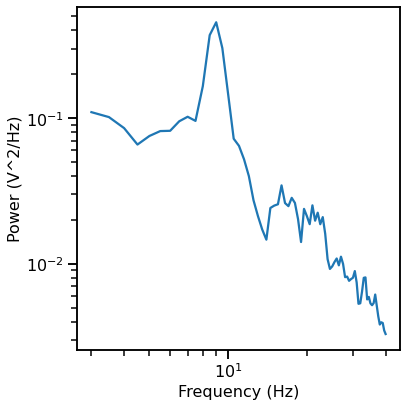

In [11]:
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

This is a replication of the 

In [12]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [13]:
# General method settings
f_range = [3, 40]

In [14]:
# Define measures to apply
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [15]:
# Initialize outputs
outputs = {func.__name__ : np.zeros(n_subjs) for func in measures.keys()}

In [16]:
# Calculate measures on data
for ind, sig in enumerate(data):
    for measure, params in measures.items():
        outputs[measure.__name__][ind] = measure(sig, **params)     

## Compare Measures

#### Compare Exponent Measures

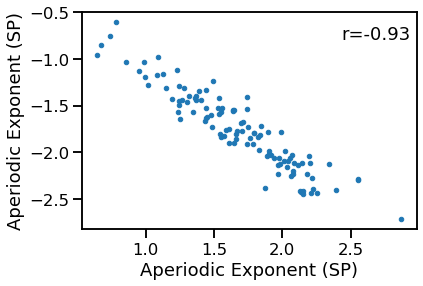

In [17]:
plot_dots(outputs['specparam'], outputs['irasa'],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (SP)')

In [18]:
sp_ir_corrs = bootstrap_corr(outputs['specparam'], outputs['irasa'])
print('  SP & IR:  ', format_corr(*sp_ir_corrs))

  SP & IR:   r=-0.932  CI[-0.953, -0.895],  p=0.000


#### Compare exponent to LZ Complexity

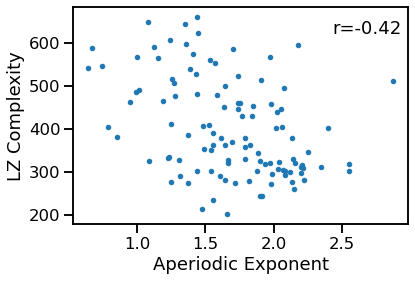

In [19]:
plot_dots(outputs['specparam'], outputs['lempelziv'],
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity')

In [20]:
sp_lzc_corrs = bootstrap_corr(outputs['specparam'], outputs['lempelziv'])
print('  EXP & LZC:  ', format_corr(*sp_lzc_corrs))

  EXP & LZC:   r=-0.422  CI[-0.566, -0.260],  p=0.000


#### Compare exponent to Entropy

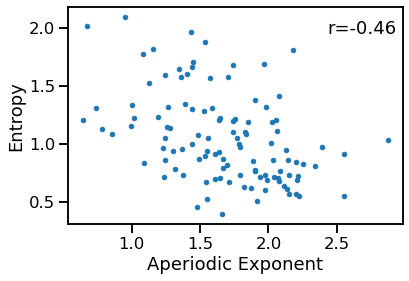

In [21]:
plot_dots(outputs['specparam'], outputs['app_entropy'],
          xlabel='Aperiodic Exponent', ylabel='Entropy')

In [22]:
sp_ent_corrs = bootstrap_corr(outputs['specparam'], outputs['app_entropy'])
print('  SP & IR:  ', format_corr(*sp_ent_corrs))

  SP & IR:   r=-0.463  CI[-0.596, -0.304],  p=0.000


## Check Age Relationship

#### Compare age to exponent

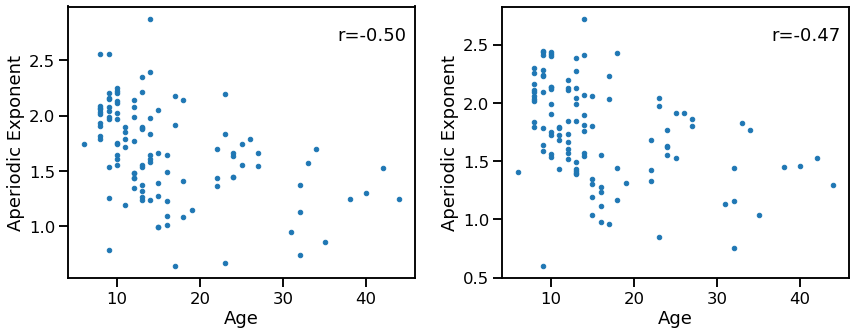

In [23]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_dots(ages, outputs['specparam'], ax=axes[0],
          xlabel='Age', ylabel='Aperiodic Exponent')
plot_dots(ages, -1 * outputs['irasa'], ax=axes[1],
          xlabel='Age', ylabel='Aperiodic Exponent')
plt.subplots_adjust(wspace=0.25)

In [24]:
sp_age_corrs = bootstrap_corr(ages, outputs['specparam'])
print('  SPEXP & age:  ', format_corr(*sp_age_corrs))

  SPEXP & age:   r=-0.502  CI[-0.624, -0.357],  p=0.000


In [25]:
sp_age_corrs = bootstrap_corr(ages, outputs['irasa'])
print('  IREXP & age:  ', format_corr(*sp_age_corrs))

  IREXP & age:   r=+0.469  CI[+0.318, +0.600],  p=0.000


In [26]:
corr_diff = bootstrap_diff(ages, outputs['specparam'], -1 * outputs['irasa'])
print('  SP & IR age diff:  ', format_corr(*corr_diff))

  SP & IR age diff:   r=-0.034  CI[-0.115, +0.045],  p=0.424


#### Compare age to LZ Complexity

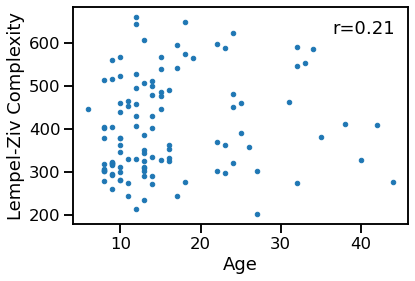

In [27]:
plot_dots(ages, outputs['lempelziv'], 
          xlabel='Age', ylabel='Lempel-Ziv Complexity')

In [28]:
lcz_age_corrs = bootstrap_corr(ages, outputs['lempelziv'])
print('  SP & age:  ', format_corr(*lcz_age_corrs))

  SP & age:   r=+0.213  CI[+0.039, +0.385],  p=0.025


#### Compare age to Hjorth Complexity

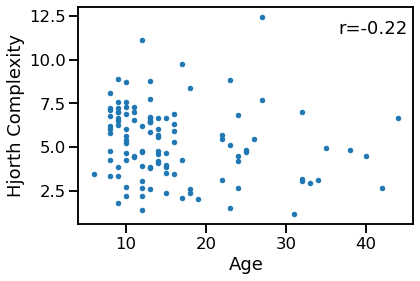

In [29]:
plot_dots(ages, outputs['hjorth_complexity'], 
          xlabel='Age', ylabel='Hjorth Complexity')

In [30]:
hcx_age_corrs = bootstrap_corr(ages, outputs['hjorth_complexity'])
print('  SP & age:  ', format_corr(*hcx_age_corrs))

  SP & age:   r=-0.218  CI[-0.397, -0.033],  p=0.021


#### Compare age to Entropy

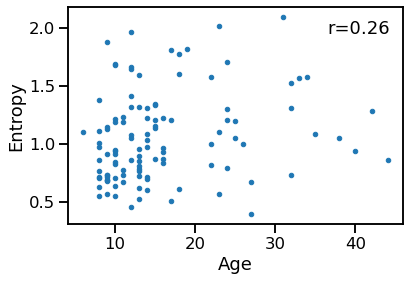

In [31]:
plot_dots(ages, outputs['app_entropy'], 
          xlabel='Age', ylabel='Entropy')

In [32]:
ent_age_corrs = bootstrap_corr(ages, outputs['app_entropy'])
print('  SP & age:  ', format_corr(*ent_age_corrs))

  SP & age:   r=+0.260  CI[+0.074, +0.428],  p=0.006


## Conclusions

Words, words, words.